In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import onnx
import onnxruntime as ort
import numpy as np

In [3]:
def distortion_free_resize(image, img_size):
    w,h = img_size
    image = tf.image.resize(image, size=(h,w), preserve_aspect_ratio = True)

    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    if pad_height%2!=0:
        height = pad_height//2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2
    
    if pad_width%2!=0:
        width = pad_width//2
        pad_width_left = width+1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width//2
    
    image =tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0,0]
        ],

    )

    image = tf.transpose(image, perm=[1,0,2])
    image = tf.image.flip_left_right(image)
    return image

In [35]:
def preprocess_image(image_path, img_size=(128, 32)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [167]:
input1 = preprocess_image("/home/sshivaditya/dev/ml-handwriting-recognition/data/data/nums/44_4288.png")


In [111]:
input1 = input1[np.newaxis, ...]

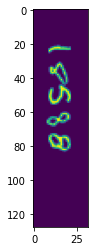

In [110]:
plt.imshow(input1)

In [97]:
model = tf.saved_model.load("/home/sshivaditya/dev/ml-handwriting-recognition/models/nummodel")
results_tf = model(np.reshape(input1, (1,128,32)),tf.random.uniform((32,10)))

In [103]:
model.predict

AttributeError: '_UserObject' object has no attribute 'predict'

In [100]:
results_tf[1]

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.1996814 , 0.99420404, 0.08808005, 0.89619744, 0.9627831 ,
        0.42473876, 0.3668797 , 0.02009058, 0.20094728, 0.5738003 ]],
      dtype=float32)>

In [ ]:
plt.imshow(np.reshape(input1, (1,128,32,1)))

In [168]:
sess = ort.InferenceSession("/home/sshivaditya/dev/ml-handwriting-recognition/models/nummodel/model.onnx", providers=["CPUExecutionProvider"])
results_ort = sess.run(["dense2"], {"x": np.reshape(input1, (1,128,32,1))})


In [169]:
input_len = np.ones(results_ort[0].shape[0])*results_ort[0].shape[1]
results = tf.keras.backend.ctc_decode(results_ort[0], input_length=input_len, greedy=True)[0][0][:, :5]

In [170]:
tf.keras.backend.get_value(results)

array([[10, 10, -1, -1, -1]])

In [157]:
voab = ['2', '7', '3', '1', '9', '6', '0', '5', '8', '4']

In [158]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
num_to_char = StringLookup(vocabulary = voab, mask_token = None, invert=True)

In [171]:
output_text = []
for res in results:
    res = tf.gather(res, tf.where(tf.math.not_equal(res,-1)))
    res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
    output_text.append(res)

In [172]:
output_text


['44']

In [76]:
results

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[ 4, 10,  5, -1, -1]])>